# Channel Break Out Detection

## Import Data

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy import stats

In [2]:
df = pd.read_csv("EURUSD_Candlestick_1_D_BID_04.05.2003-21.01.2023.csv")

## Detect Pivots/Fractals

In [3]:
def isPivot(candle, window):
    """
    function that detects if a candle is a pivot/fractal point
    args: candle index, window before and after candle to test if pivot
    returns: 1 if pivot high, 2 if pivot low, 3 if both and 0 default
    """
    if candle-window < 0 or candle+window >= len(df):
        return 0
    
    pivotHigh = 1
    pivotLow = 2
    for i in range(candle-window, candle+window+1):
        if df.iloc[candle].Low > df.iloc[i].Low:
            pivotLow=0
        if df.iloc[candle].High < df.iloc[i].High:
            pivotHigh=0
    if (pivotHigh and pivotLow):
        return 3
    elif pivotHigh:
        return pivotHigh
    elif pivotLow:
        return pivotLow
    else:
        return 0
    

In [4]:
window=3
df['isPivot'] = df.apply(lambda x: isPivot(x.name,window), axis=1)

In [5]:
def pointpos(x):
    if x['isPivot']==2:
        return x['Low']-1e-3
    elif x['isPivot']==1:
        return x['High']+1e-3
    else:
        return np.nan
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)

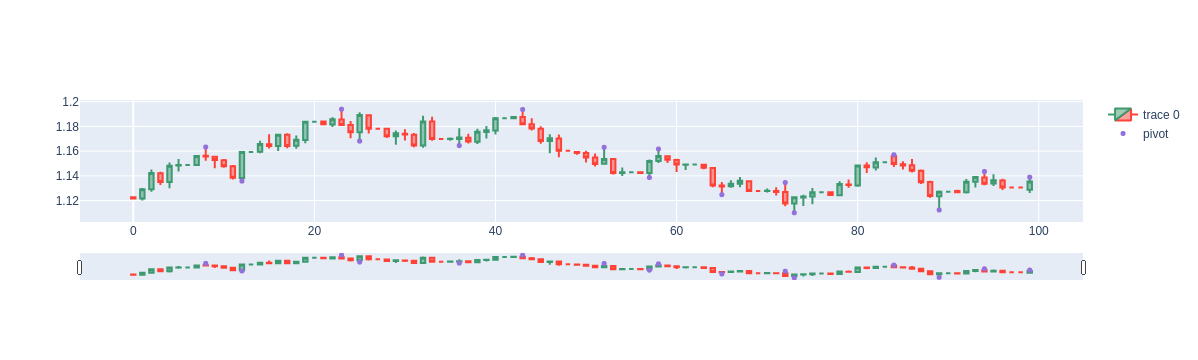

In [26]:
dfpl = df[0:100]
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
#fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

## Detect Price Channel

In [27]:
def collect_channel(candle, backcandles, window):
    localdf = df[candle-backcandles-window:candle-window]
    localdf['isPivot'] = localdf.apply(lambda x: isPivot(x.name,window), axis=1)
    highs = localdf[localdf['isPivot']==1].High.values
    idxhighs = localdf[localdf['isPivot']==1].High.index
    lows = localdf[localdf['isPivot']==2].Low.values
    idxlows = localdf[localdf['isPivot']==2].Low.index
    
    if len(lows)>=2 and len(highs)>=2:
        sl_lows, interc_lows, r_value_l, _, _ = stats.linregress(idxlows,lows)
        sl_highs, interc_highs, r_value_h, _, _ = stats.linregress(idxhighs,highs)
    
        return(sl_lows, interc_lows, sl_highs, interc_highs, r_value_l**2, r_value_h**2)
    else:
        return(0,0,0,0,0,0)
    

0.9934618656317556 0.8685739172605113


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



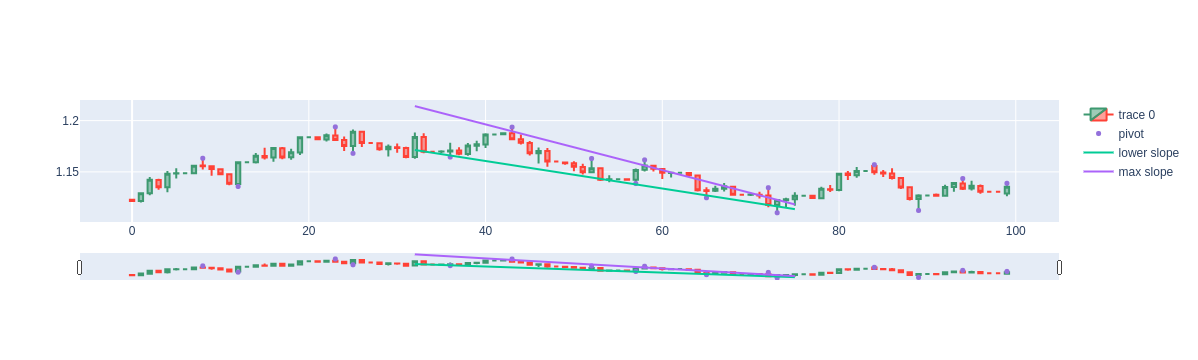

In [28]:
candle = 75
backcandles = 40
window = 3

#dfpl = df[candle-backcandles-window-5:candle+200]

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")

sl_lows, interc_lows, sl_highs, interc_highs, r_sq_l, r_sq_h = collect_channel(candle, backcandles, window)
print(r_sq_l, r_sq_h)
x = np.array(range(candle-backcandles-window, candle+1))
fig.add_trace(go.Scatter(x=x, y=sl_lows*x + interc_lows, mode='lines', name='lower slope'))
fig.add_trace(go.Scatter(x=x, y=sl_highs*x + interc_highs, mode='lines', name='max slope'))
#fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

## Detect Break Out

In [29]:
def isBreakOut(candle, backcandles, window):
    if (candle-backcandles-window)<0:
        return 0
    
    sl_lows, interc_lows, sl_highs, interc_highs, r_sq_l, r_sq_h = collect_channel(candle, 
                                                                                   backcandles, 
                                                                                   window)
    
    prev_idx = candle-1
    prev_high = df.iloc[candle-1].High
    prev_low = df.iloc[candle-1].Low
    prev_close = df.iloc[candle-1].Close
    
    curr_idx = candle
    curr_high = df.iloc[candle].High
    curr_low = df.iloc[candle].Low
    curr_close = df.iloc[candle].Close
    curr_open = df.iloc[candle].Open

    if ( prev_high > (sl_lows*prev_idx + interc_lows) and
        prev_close < (sl_lows*prev_idx + interc_lows) and
        curr_open < (sl_lows*curr_idx + interc_lows) and
        curr_close < (sl_lows*prev_idx + interc_lows)): #and r_sq_l > 0.9
        return 1
    
    elif ( prev_low < (sl_highs*prev_idx + interc_highs) and
        prev_close > (sl_highs*prev_idx + interc_highs) and
        curr_open > (sl_highs*curr_idx + interc_highs) and
        curr_close > (sl_highs*prev_idx + interc_highs)): #and r_sq_h > 0.9
        return 2
    
    else:
        return 0

In [31]:
def breakpointpos(x):
    if x['isBreakOut']==2:
        return x['Low']-3e-3
    elif x['isBreakOut']==1:
        return x['High']+3e-3
    else:
        return np.nan

candle = 75
backcandles = 40
window = 3
dfpl = df[candle-backcandles-window-5:candle+20]
dfpl["isBreakOut"] = [isBreakOut(candle, backcandles, window) for candle in dfpl.index]
dfpl['breakpointpos'] = dfpl.apply(lambda row: breakpointpos(row), axis=1)

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [33]:
candle = 59

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")

fig.add_scatter(x=dfpl.index, y=dfpl['breakpointpos'], mode="markers",
                marker=dict(size=8, color="Black"), marker_symbol="hexagram",
                name="pivot")

sl_lows, interc_lows, sl_highs, interc_highs, r_sq_l, r_sq_h = collect_channel(candle, backcandles, window)
print(r_sq_l, r_sq_h)
x = np.array(range(candle-backcandles-window, candle+1))
fig.add_trace(go.Scatter(x=x, y=sl_lows*x + interc_lows, mode='lines', name='lower slope'))
fig.add_trace(go.Scatter(x=x, y=sl_highs*x + interc_highs, mode='lines', name='max slope'))
#fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

1.0 0.5525995544506749


D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

